# Creating a Kaggle Workflow

In this mission, we're going to explore a workflow to make competing in the Kaggle [Titanic competition](https://www.kaggle.com/c/titanic) easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def workflow(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    df = create_dummies(df, ["Age_categories", 
                             "Fare_categories",
                             "Title", 
                             "Cabin_type", 
                             "Sex"])
    return df

In [5]:
train_clean = workflow(train)
holdout_clean = workflow(holdout)

We are going to examine the two columns that contain information about the family members each passenger had onboard: `SibSp` and `Parch`. We will set the mean survival rate among all passengers as our baseline to decide if a feature provides a great survival chance than the average, 0.3838.

In [6]:
train_clean['Survived'].mean()

0.3838383838383838

<ipython-input-7-9c328dd9602f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Histogram of SibSp, Parch & Total family members')

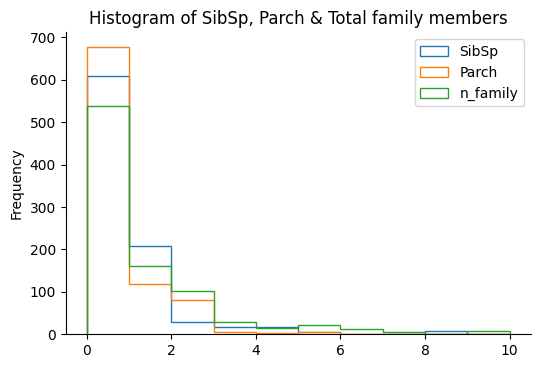

In [7]:
explore_cols = ['SibSp', 'Parch', 'Survived']
explore = train_clean[explore_cols]
explore['n_family'] = explore['SibSp'] + explore['Parch']

ax = explore.drop('Survived', axis=1).plot.hist(histtype='step') 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Histogram of SibSp, Parch & Total family members')

Most of the passengers do not have any fmaily members aboard.

In [8]:
# function to plot the surival rate against feature
def survival_plot(col):
    
    survival_rate = pd.pivot_table(explore, 
                                   index = col, 
                                   values='Survived')
    
    ax = survival_rate.plot.bar()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.hlines(y=0.3838, xmin=-1, xmax=10, 
               alpha = 0.5, color ='red', linestyles='dashdot')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge
    plt.title('Survival rate against '+col)

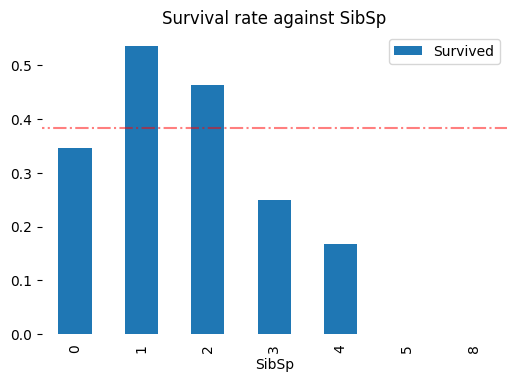

In [9]:
survival_plot('SibSp')

Passengers with 1 or 2 siblings/spouses aboard have a better survival rate than the average while passengers without siblings/spouses aboard have a worse survival rate.

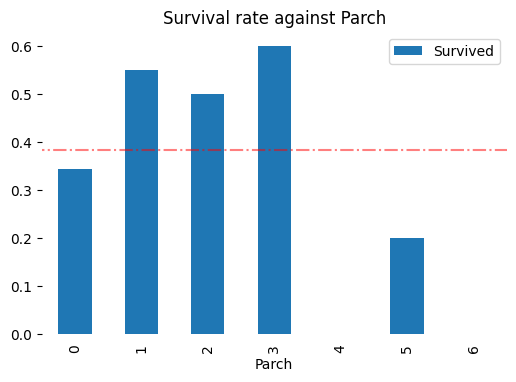

In [10]:
survival_plot('Parch')

A similar situation happens for the passengers with parents/children aboard: their survival rate is higher than the average while those without parents/children are lower than average.

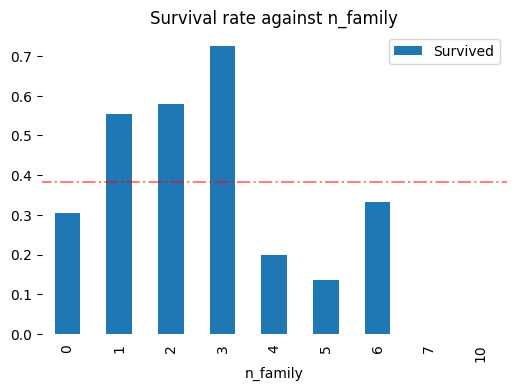

In [11]:
survival_plot('n_family')

Considering the number of passengers with more than 3 family members aboard is not significant, we can conclude that the survival rate varies when the passengers are alone or accompanied. We will add this feature, `isalone`, in our data set.

In [56]:
train_clean['isalone'] = (train_clean['SibSp'] + train_clean['Parch'])==0
holdout_clean['isalone'] = (holdout_clean['SibSp'] + holdout_clean['Parch'])==0

## Feature selection

Now we will try to find out the best-performing features using recursive feature elimination. In addition, we will use Random Forests for the selection.

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Removes any non-numeric columns or columns containing null values
    data = df.select_dtypes(exclude = ['category','object']).dropna()
    
    # split features and target
    all_X = data[data.columns.drop(['PassengerId', 'Survived'])]
    all_y = data['Survived']
    
    rf = RandomForestClassifier(random_state = 1)
    selector = RFECV(rf, cv=10)
    selector = selector.fit(all_X, all_y)
    
    # best performing features
    selected_features = all_X.columns[selector.support_]
    print('Best columns:', '\n', selected_features)
    
    return selected_features

In [25]:
selected_features = select_features(train_clean)

Best columns: 
 Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')


## Model selection

After finding out the best-performing features, we turn our attention to the models. We will compare the results from KNN, logistic regression and random forest with their best parameters.

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [47]:
def select_model(df, features, target):
    all_X = df[features]
    all_y = df[target]
    
    models = [{'name': 'LogisticRegression',
               'estimator': LogisticRegression(),
               'hyperparameters':{
                   'solver': ["newton-cg", "lbfgs", "liblinear"]
               }
              }, 
              {'name': 'KNeighborsClassifier',
               'estimator': KNeighborsClassifier(),
               'hyperparameters':{
                   "n_neighbors": range(1,20,2),
                   "weights": ["distance", "uniform"],
                   "algorithm": ["ball_tree", "kd_tree", "brute"],
                   "p": [1,2]
                }
               },
              {'name': 'RandomForestClassifier',
               'estimator': RandomForestClassifier(),
               'hyperparameters':{
                   "n_estimators": [4, 6, 9],
                   "criterion": ["entropy", "gini"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]
               }
              }]
    
    model_best = []
    i = 0
    for model in models:
        grid = GridSearchCV(model['estimator'], 
                            param_grid=model['hyperparameters'],
                            cv=10)
        grid.fit(all_X, all_y)
        best_params = grid.best_params_
        best_score = grid.best_score_
        model_best.append(grid.best_estimator_)
        print('Model number ', i,' :', model['name'])
        print(best_params)
        print(best_score)
        print('\n')
        i+=1
    
    return model_best

In [48]:
model = select_model(train_clean, selected_features, 'Survived')

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

LogisticRegression
{'solver': 'lbfgs'}
0.8204744069912608
KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.7767041198501874
RandomForestClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}
0.8418352059925093


Random forest with its best parameters provides the best score among all models. We will use it to predcit our result.

## Submission

Now we can decide which model to use for our submission. However, we still need to fit our result into the required format as *holdout*. 

In [62]:
def save_submission_file(model, features, *filename):
    prediction = model.predict(holdout_clean[features])
    submission = pd.DataFrame({
        'PassengerId': holdout['PassengerId'],
        'Survived': prediction
    })
    submission.to_csv(filename, index=False)
    return submission

In [65]:
save_submission_file(model[2], selected_features, 'sub.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
